# Deep Learning Course Project - Gesture Recognition

- Arunava Bhattacharya
- Aditya Yadav

In this project the key steps are performed
1. Load and process the data
2. Use multiple modelling technique like CNN-RNN stack or 3D Conv model to find out best model suited best gesture recognition problem
3. Once the best model is identified using train data, need to run the model over validations data as provided to measure various parameters for verify efficiency of the model
4. Overall the goal is to build an efficinet model which predicts 5 gesture correctly

As the first step, lets mount the google colab drive so that the files can be accessed from google drive. We have used google colab due to computation power and maximise GPU

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import os
from skimage import io
import datetime
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn
from keras import backend as K
import tensorflow as tf

In [3]:
#Lets set random seed to 30 so that result doesn't vary drastically
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

Lets read the folder names for training and validation. 

Lets also set the `batch_size` as 10 intially and keep increasing the batch size until the machine throws an error.

In [4]:
# Training data
train_doc = np.random.permutation(open('/content/drive/My Drive/Colab Notebooks/Project_data/train.csv').readlines())

#Validation data
val_doc = np.random.permutation(open('/content/drive/My Drive/Colab Notebooks/Project_data/val.csv').readlines())

#Setting batch size to 10
batch_size = 10

In [5]:
#lets resize the image with size 120x120
rows = 120
cols = 120

In [6]:
#lets understand the current distribution of class as EDA
train_df = pd.DataFrame()
frame_name = []
frame_target = []
frame_class = []


for train_data in train_doc:
    data = train_data.split(";")
    frame_name.append(data[0])
    frame_target.append(data[1])
    frame_class.append(data[2].strip())
   
train_df["Video_Name"] = frame_name
train_df["Action_name"] = frame_target
train_df["Action_Class"] = frame_class

train_df.head()

,Video_Name,Action_name,Action_Class
0,WIN_20180926_16_54_08_Pro_Right_Swipe_new,Right_Swipe_new,1
1,WIN_20180925_18_02_58_Pro_Thumbs_Down_new,Thumbs_Down_new,3
2,WIN_20180925_17_33_08_Pro_Left_Swipe_new,Left_Swipe_new,0
3,WIN_20180925_17_51_17_Pro_Thumbs_Up_new,Thumbs_Up_new,4
4,WIN_20180926_17_17_35_Pro_Left_Swipe_new,Left_Swipe_new,0


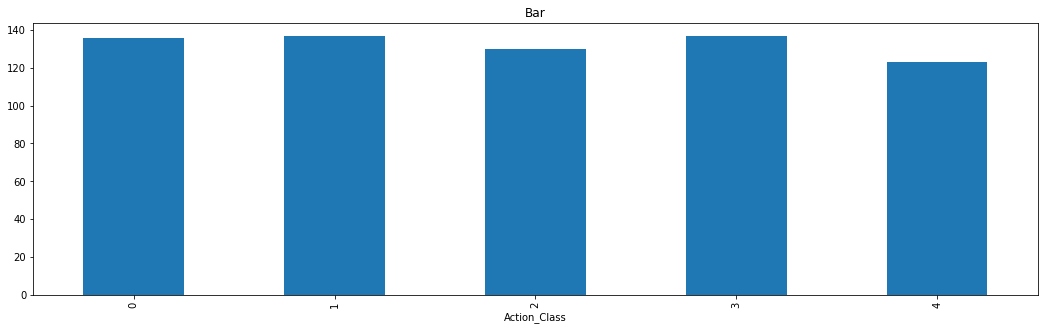

In [7]:
# plotting to see the distribution of classes
train_df.Action_Class.value_counts()

size = [train_df.Action_Class.value_counts()[0],train_df.Action_Class.value_counts()[1],
        train_df.Action_Class.value_counts()[2],train_df.Action_Class.value_counts()[3],
        train_df.Action_Class.value_counts()[4]]
lables = ['3','1','0','2','4']

plt.figure(figsize=(18,5))

plt.title('Bar')
train_df.groupby('Action_Class').Action_name.count().plot(kind='bar') #Balanced
plt.show()

# Generator
This is one of the most important part of the code. In the generator, we are going to preprocess the images as we have images of 2 different dimensions as well as create a batch of video frames. we have chosen `img_idx`, `y`,`z` and normalization in such a way that we get high accuracy.

In [8]:
# Lets resize all the images to ensure all the images are in same size
def crop_resize_img (image):
    if image.shape[0] != image.shape[1]:
        image = image[0:120,10:150]
    resized_image = cv2.resize(image, (120,120))
    return resized_image

In [9]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(5,25))
    x = len(img_idx)
    y = 120
    z = 120
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)//batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    resized_img = crop_resize_img(image)
                    
                    batch_data[folder,idx,:,:,0] = resized_img[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = resized_img[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = resized_img[:,:,2]/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #yield the batch_data and the batch_labels
            

        
        # code for the remaining data points which are left after full batches
        if int(len(t)%batch_size!=0):
            rest_videos_count = int(len(t)%batch_size)
            for folder in range(rest_videos_count): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + ((num_batches)*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + ((num_batches)*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them
                    resized_img = crop_resize_img(image) #resizing the image
                    
                    batch_data[folder,idx,:,:,0] = resized_img[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resized_img[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resized_img[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #yield the batch_data and the batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). We have taken this into consideration while creating the model architecture.

In [10]:
#Lets define the global parameters requires for this solution 
curr_dt_time = datetime.datetime.now()

train_path = '/content/drive/My Drive/Colab Notebooks/Project_data/train'
val_path = '/content/drive/My Drive/Colab Notebooks/Project_data/val'


num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here we make the model using different functionalities that Keras provides. We have used `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. We have used `TimeDistributed` while building a Conv2D + RNN model. Also we have considered that the last layer is the softmax and we have designed the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [11]:
#Lets include more libraries thats required
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers import Bidirectional,LSTM, SimpleRNN, GRU
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers

Now that we have written the model, the next step is to `compile` the model. When we print the `summary` of the model, we'll see the total number of parameters we have to train.

In [12]:
frame = 20
rows = 120
cols = 120
channel_color = 3
num_classes = 5

# Architecutre 1 - Conv3d -------------------------------------------------

# Model 1 : Vanilla Conv3d

In [13]:
#Lets make the vanilla model
model = Sequential()

model.add(Conv3D(32, kernel_size = (3,3,3), padding = "same", activation = "relu" , input_shape = (frame, rows, cols, channel_color)))
model.add(BatchNormalization())

#HL1
model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#HL2
model.add(Conv3D(128, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#Fully connected
model.add(Flatten())
model.add(Dense(256,  activation = "relu"))

#output layer
model.add(Dense(num_classes, activation = "softmax"))


In [14]:
#Lets use the optimiser and compile the model
optimiser = "adam"
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 120, 120, 32)  2624      
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 120, 120, 32)  128       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 20, 120, 120, 64)  55360     
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 120, 120, 64)  256       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 60, 60, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 60, 60, 128)   221312    
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 60, 60, 128)   5

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [15]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [16]:
#Lets save the model checkpoint and define the LR
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor = "val_loss", fractor = 0.5, patience = 2, cooldown = 1, verbose = 1)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [17]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    
print("Train Epoch value: ", steps_per_epoch)
print("Val Epoch value: ", validation_steps)

Train Epoch value:  67
Val Epoch value:  10


Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [18]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/My Drive/Colab Notebooks/Project_data/train ; batch size = 10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
67/67 [==============================] - 2883s 43s/step - loss: 181.5822 - categorical_accuracy: 0.3523 - val_loss: 106.4481 - val_categorical_accuracy: 0.2400

Epoch 00001: val_loss improved from inf to 106.44807, saving model to model_init_2021-05-0214_52_47.962411/model-00001-107.67776-0.37761-106.44807-0.24000.h5
Epoch 2/10
67/67 [==============================] - 74s 1s/step - loss: 18.0534 - categorical_accuracy: 0.4102 - val_loss: 166.5200 - val_categorical_accuracy: 0.1400

Epoch 00002: val_loss did not improve from 106.44807
Epoch 3/10
67/67 [==============================] - 72s 1s/step - loss: 6.7763 - categorical_accuracy: 0.4130 - val_loss: 56.4780 - val_categorical_accuracy: 0.2700

Epoch 00003: val_loss improved from 106.44807 to 56.47799, saving model to model_init_2021-05-0214_52_47.962411/model-00003-6.74622-0.41194-56.47799-0.27000.h5
Epoch 4/10
67/67 [==============================] - 73s 1s/step - loss: 2.5322 - categorical_accuracy: 0.4424 - val_loss: 4

In [19]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'], loc='upper left')

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'], loc='upper left')

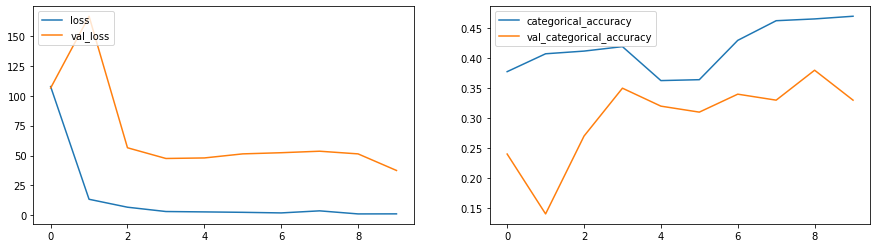

In [20]:
plot(history)

In [21]:
model_detail_df = pd.DataFrame()

In [22]:
def model_result(model_name ,accuracy, loss, val_accuracy, val_loss):
    model_detail_dic = {"Model Name" : model_name,
                   "Model Accuracy" : accuracy * 100,
                   "Model Loss" : loss * 100 ,
                   "Val Accuracy" : val_accuracy * 100,
                   "Val Loss" : val_loss * 100}

    df = pd.DataFrame([model_detail_dic])
    return df
    

In [23]:
df1 = model_result("Model_1_Vanilla",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

        Model Name  Model Accuracy  Model Loss  Val Accuracy     Val Loss
0  Model_1_Vanilla       47.014925  117.855895     33.000001  3748.384857


# Model 2 : Reducing Filter (2,2,2) & Added few more Hyper Tuning Paramaters

In [28]:
#Let's try reducing the filter 
# Added Batch normalization to each layer

model2 = Sequential()

model2.add(Conv3D(16, kernel_size=(2,2,2), padding='same', activation='relu',input_shape = (20,120,120,3)))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(32, kernel_size=(2,2,2), padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv3D(64, kernel_size=(2,2,2), padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv3D(128, kernel_size=(2,2,2), padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Flatten())
model2.add(Dense(512,kernel_regularizer=l2(0.01),activation='relu'))
model2.add(Dropout(0.50))

model2.add(Dense(5, activation = 'softmax'))

optimiser = 'adam'
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_3 (Batch (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
batch_normalization_4 (Batch (None, 10, 60, 60, 32)    128       
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 5, 30, 30, 32)     0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 30, 30, 32)    

In [29]:
history = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
67/67 [==============================] - 62s 916ms/step - loss: 18.9728 - categorical_accuracy: 0.3116 - val_loss: 15.0976 - val_categorical_accuracy: 0.2400

Epoch 00001: val_loss did not improve from 9.97995
Epoch 2/10
67/67 [==============================] - 61s 918ms/step - loss: 7.5402 - categorical_accuracy: 0.5877 - val_loss: 17.9368 - val_categorical_accuracy: 0.2000

Epoch 00002: val_loss did not improve from 9.97995
Epoch 3/10
67/67 [==============================] - 60s 909ms/step - loss: 5.9150 - categorical_accuracy: 0.6981 - val_loss: 12.2393 - val_categorical_accuracy: 0.2200

Epoch 00003: val_loss did not improve from 9.97995
Epoch 4/10
67/67 [==============================] - 61s 915ms/step - loss: 4.6821 - categorical_accuracy: 0.7496 - val_loss: 11.7280 - val_categorical_accuracy: 0.2600

Epoch 00004: val_loss did not improve from 9.97995
Epoch 5/10
67/67 [==============================] - 60s 911ms/step - loss: 3.7797 - categorical_accuracy: 0.8151 - val_

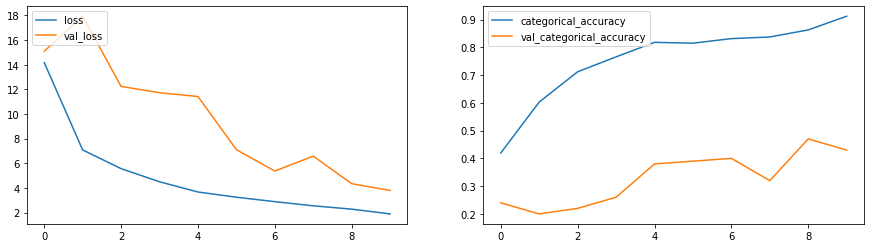

In [30]:
plot(history)

In [31]:
df1 = model_result("Model_2_Tuning",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

        Model Name  Model Accuracy  Model Loss  Val Accuracy     Val Loss
0  Model_1_Vanilla       47.014925  117.855895     33.000001  3748.384857
0      Model_3_SGD       69.402987  951.683807     47.000000  1007.729626
0   Model_2_Tuning       91.194028  188.983715     43.000001   379.239225


#  Model 3: changing optimizer to "SGD" & Added L2 Regularization

In [24]:
#Let's try 'sgd' as optimizer on same architecture with 10 epochs

model = Sequential()


model.add(Conv3D(16, kernel_size=(3,3,3), padding='same', activation='relu',input_shape = (20,120,120,3)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(128, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(512,kernel_regularizer=l2(0.01),activation='relu'))
model.add(Dropout(0.50))



model.add(Dense(5, activation = 'softmax'))

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_3 (Batch (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
batch_normalization_4 (Batch (None, 10, 60, 60, 32)    128       
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 5, 30, 30, 32)     0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 30, 30, 32)    

In [25]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
67/67 [==============================] - 63s 919ms/step - loss: 14.7493 - categorical_accuracy: 0.2619 - val_loss: 10.7107 - val_categorical_accuracy: 0.3600

Epoch 00001: val_loss improved from 37.48385 to 10.71067, saving model to model_init_2021-05-0214_52_47.962411/model-00001-12.41930-0.33582-10.71067-0.36000.h5
Epoch 2/10
67/67 [==============================] - 61s 924ms/step - loss: 10.4166 - categorical_accuracy: 0.5446 - val_loss: 12.0132 - val_categorical_accuracy: 0.2300

Epoch 00002: val_loss did not improve from 10.71067
Epoch 3/10
67/67 [==============================] - 60s 912ms/step - loss: 10.1200 - categorical_accuracy: 0.5630 - val_loss: 11.7848 - val_categorical_accuracy: 0.3100

Epoch 00003: val_loss did not improve from 10.71067

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 4/10
67/67 [==============================] - 61s 921ms/step - loss: 9.7004 - categorical_accuracy: 0.6473 - val_loss: 11.3632 - val_catego

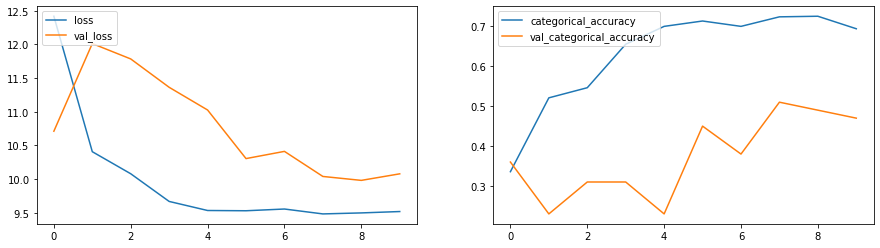

In [26]:
plot(history)

In [27]:
df1 = model_result("Model_3_SGD",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

        Model Name  Model Accuracy  Model Loss  Val Accuracy     Val Loss
0  Model_1_Vanilla       47.014925  117.855895     33.000001  3748.384857
0      Model_3_SGD       69.402987  951.683807     47.000000  1007.729626


# Model 4 : Adding more Conv Layer

In [32]:
# Adding more layer to the architecture 

model = Sequential()


model.add(Conv3D(16, kernel_size=(3,3,3), padding='same', activation='relu',input_shape = (20,120,120,3)))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2, 2, 2)))
## h1,2
model.add(Conv3D(32, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2, 2, 2)))

## h3,4
model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())


model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2, 2, 2)))

## h5,6
model.add(Conv3D(128, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(Conv3D(128, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(256,kernel_regularizer=l2(0.01),activation='relu'))
model.add(Dropout(0.50))

model.add(Dense(5, activation = 'softmax'))

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_11 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_11 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
batch_normalization_12 (Batc (None, 10, 60, 60, 32)    128       
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 10, 60, 60, 32)    27680     
_________________________________________________________________
batch_normalization_13 (Batc (None, 10, 60, 60, 32)   

In [33]:

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
67/67 [==============================] - 64s 935ms/step - loss: 11.3232 - categorical_accuracy: 0.2439 - val_loss: 8.2492 - val_categorical_accuracy: 0.2400

Epoch 00001: val_loss did not improve from 3.79239
Epoch 2/10
67/67 [==============================] - 62s 938ms/step - loss: 6.1757 - categorical_accuracy: 0.4322 - val_loss: 6.5503 - val_categorical_accuracy: 0.3000

Epoch 00002: val_loss did not improve from 3.79239
Epoch 3/10
67/67 [==============================] - 62s 933ms/step - loss: 5.8021 - categorical_accuracy: 0.5709 - val_loss: 6.7009 - val_categorical_accuracy: 0.3300

Epoch 00003: val_loss did not improve from 3.79239
Epoch 4/10
67/67 [==============================] - 62s 935ms/step - loss: 5.5681 - categorical_accuracy: 0.6193 - val_loss: 5.7429 - val_categorical_accuracy: 0.4500

Epoch 00004: val_loss did not improve from 3.79239
Epoch 5/10
67/67 [==============================] - 62s 940ms/step - loss: 5.3893 - categorical_accuracy: 0.6330 - val_loss

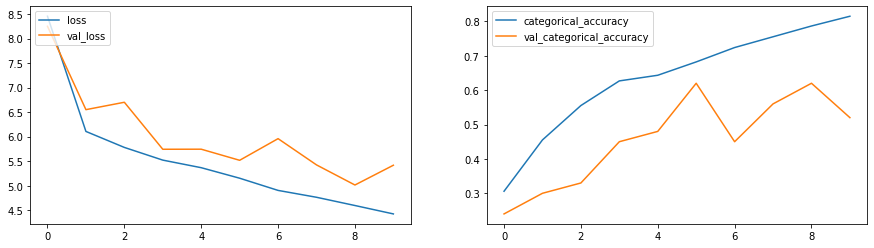

In [34]:
plot(history)

In [35]:
df1 = model_result("Model_2_Add_HL",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

        Model Name  Model Accuracy  Model Loss  Val Accuracy     Val Loss
0  Model_1_Vanilla       47.014925  117.855895     33.000001  3748.384857
0      Model_3_SGD       69.402987  951.683807     47.000000  1007.729626
0   Model_2_Tuning       91.194028  188.983715     43.000001   379.239225
0   Model_2_Add_HL       81.492537  442.510700     51.999998   541.738272


# Model 5 : Adding one more dense layer with filter size (2,2,2)

In [36]:
#Let's try reducing the filter 
# Added Batch normalization to each layer
#

model = Sequential()

model.add(Conv3D(16, kernel_size=(2,2,2), padding='same', activation='relu',input_shape = (20,120,120,3)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, kernel_size=(2,2,2), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=(2,2,2), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(128, kernel_size=(2,2,2), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))


model.add(Flatten())
model.add(Dense(256,kernel_regularizer=l2(0.01),activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(512,kernel_regularizer=l2(0.01),activation='relu'))
model.add(Dropout(0.50))

model.add(Dense(5, activation = 'softmax'))

optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_18 (Conv3D)           (None, 20, 120, 120, 16)  400       
_________________________________________________________________
batch_normalization_18 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_14 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 10, 60, 60, 32)    4128      
_________________________________________________________________
batch_normalization_19 (Batc (None, 10, 60, 60, 32)    128       
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 5, 30, 30, 32)     0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 5, 30, 30, 32)    

In [37]:

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
67/67 [==============================] - 62s 918ms/step - loss: 13.9686 - categorical_accuracy: 0.2504 - val_loss: 17.6395 - val_categorical_accuracy: 0.2100

Epoch 00001: val_loss did not improve from 3.79239
Epoch 2/10
67/67 [==============================] - 60s 912ms/step - loss: 6.4785 - categorical_accuracy: 0.4131 - val_loss: 17.3933 - val_categorical_accuracy: 0.2000

Epoch 00002: val_loss did not improve from 3.79239
Epoch 3/10
67/67 [==============================] - 61s 916ms/step - loss: 5.2874 - categorical_accuracy: 0.4256 - val_loss: 11.0243 - val_categorical_accuracy: 0.2400

Epoch 00003: val_loss did not improve from 3.79239
Epoch 4/10
67/67 [==============================] - 60s 914ms/step - loss: 4.4622 - categorical_accuracy: 0.4938 - val_loss: 12.1976 - val_categorical_accuracy: 0.2300

Epoch 00004: val_loss did not improve from 3.79239
Epoch 5/10
67/67 [==============================] - 60s 912ms/step - loss: 3.8443 - categorical_accuracy: 0.5522 - val_

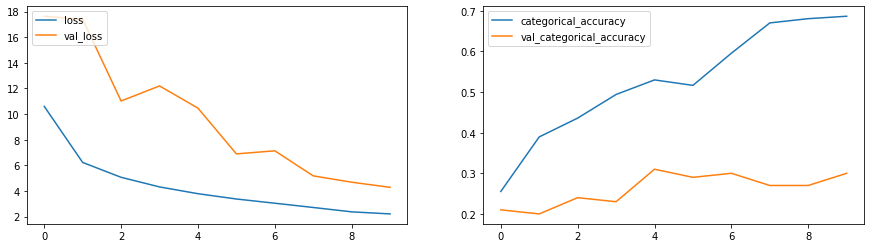

In [38]:
plot(history)

In [39]:
df1 = model_result("Model_5_Tuning",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

        Model Name  Model Accuracy  Model Loss  Val Accuracy     Val Loss
0  Model_1_Vanilla       47.014925  117.855895     33.000001  3748.384857
0      Model_3_SGD       69.402987  951.683807     47.000000  1007.729626
0   Model_2_Tuning       91.194028  188.983715     43.000001   379.239225
0   Model_2_Add_HL       81.492537  442.510700     51.999998   541.738272
0   Model_5_Tuning       68.656719  220.471096     30.000001   427.992392


#  Architecutre 2 - Combination of CNN and RNN (CNN + RNN) -------------

#  Model 6: CNN + SimpleRNN Network

In [40]:
input_shape = (frame, rows, cols, channel_color)

In [41]:
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape = input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))


model.add(SimpleRNN(256))

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(5, activation='softmax'))


optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 30, 30, 64)   

In [42]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
67/67 [==============================] - 63s 912ms/step - loss: 1.7525 - categorical_accuracy: 0.3375 - val_loss: 2.9429 - val_categorical_accuracy: 0.1800

Epoch 00001: val_loss improved from 3.79239 to 2.94290, saving model to model_init_2021-05-0214_52_47.962411/model-00001-1.52887-0.39104-2.94290-0.18000.h5
Epoch 2/10
67/67 [==============================] - 61s 917ms/step - loss: 1.1133 - categorical_accuracy: 0.5839 - val_loss: 2.2689 - val_categorical_accuracy: 0.2900

Epoch 00002: val_loss improved from 2.94290 to 2.26886, saving model to model_init_2021-05-0214_52_47.962411/model-00002-1.09420-0.58060-2.26886-0.29000.h5
Epoch 3/10
67/67 [==============================] - 61s 924ms/step - loss: 0.8943 - categorical_accuracy: 0.6261 - val_loss: 2.6245 - val_categorical_accuracy: 0.2900

Epoch 00003: val_loss did not improve from 2.26886
Epoch 4/10
67/67 [==============================] - 61s 925ms/step - loss: 0.8346 - categorical_accuracy: 0.6747 - val_loss: 3.7484 -

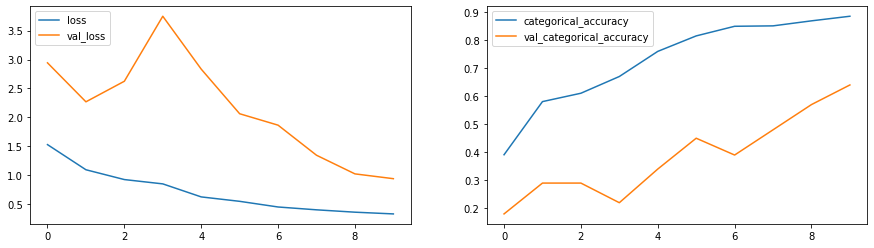

In [43]:
plot(history)

In [44]:
df1 = model_result("Model_6_CNN_RNN",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

        Model Name  Model Accuracy  Model Loss  Val Accuracy     Val Loss
0  Model_1_Vanilla       47.014925  117.855895     33.000001  3748.384857
0      Model_3_SGD       69.402987  951.683807     47.000000  1007.729626
0   Model_2_Tuning       91.194028  188.983715     43.000001   379.239225
0   Model_2_Add_HL       81.492537  442.510700     51.999998   541.738272
0   Model_5_Tuning       68.656719  220.471096     30.000001   427.992392
0  Model_6_CNN_RNN       88.507462   33.057642     63.999999    93.978983


In [45]:
print(model_detail_df.head(20))

        Model Name  Model Accuracy  Model Loss  Val Accuracy     Val Loss
0  Model_1_Vanilla       47.014925  117.855895     33.000001  3748.384857
0      Model_3_SGD       69.402987  951.683807     47.000000  1007.729626
0   Model_2_Tuning       91.194028  188.983715     43.000001   379.239225
0   Model_2_Add_HL       81.492537  442.510700     51.999998   541.738272
0   Model_5_Tuning       68.656719  220.471096     30.000001   427.992392
0  Model_6_CNN_RNN       88.507462   33.057642     63.999999    93.978983


# Model 7: CNN + SimpleRNN Network(Added more cells, Added Dropout in HL)

In [46]:
model = Sequential()

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu'),input_shape = input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.2))


model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.2))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.2))

model.add(TimeDistributed(Flatten()))


model.add(SimpleRNN(512))

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(5, activation='softmax'))


optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_13 (TimeDis (None, 20, 120, 120, 32)  896       
_________________________________________________________________
time_distributed_14 (TimeDis (None, 20, 120, 120, 32)  128       
_________________________________________________________________
time_distributed_15 (TimeDis (None, 20, 60, 60, 32)    0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 20, 60, 60, 64)    18496     
_________________________________________________________________
time_distributed_17 (TimeDis (None, 20, 60, 60, 64)    256       
_________________________________________________________________
time_distributed_18 (TimeDis (None, 20, 30, 30, 64)    0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 20, 30, 30, 64)   

In [47]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
67/67 [==============================] - 65s 935ms/step - loss: 1.9927 - categorical_accuracy: 0.2801 - val_loss: 4.1132 - val_categorical_accuracy: 0.2100

Epoch 00001: val_loss did not improve from 0.93979
Epoch 2/10
67/67 [==============================] - 61s 928ms/step - loss: 1.2848 - categorical_accuracy: 0.4561 - val_loss: 3.5747 - val_categorical_accuracy: 0.1500

Epoch 00002: val_loss did not improve from 0.93979
Epoch 3/10
67/67 [==============================] - 61s 926ms/step - loss: 1.1058 - categorical_accuracy: 0.5374 - val_loss: 3.5372 - val_categorical_accuracy: 0.1800

Epoch 00003: val_loss did not improve from 0.93979
Epoch 4/10
67/67 [==============================] - 62s 931ms/step - loss: 0.8339 - categorical_accuracy: 0.6147 - val_loss: 2.9027 - val_categorical_accuracy: 0.2700

Epoch 00004: val_loss did not improve from 0.93979
Epoch 5/10
67/67 [==============================] - 62s 938ms/step - loss: 0.8923 - categorical_accuracy: 0.6275 - val_loss:

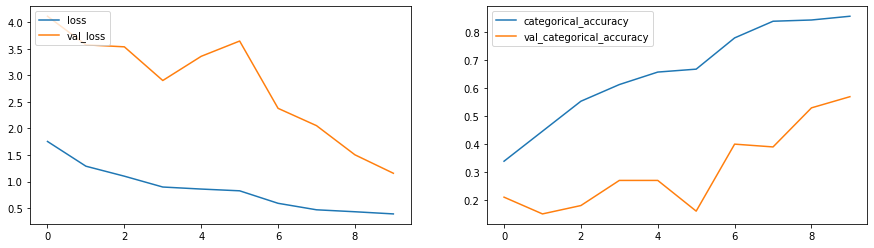

In [48]:
plot(history)

In [49]:
df1 = model_result("Model_7_CNN_RNN_Add_Tuning",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

                   Model Name  Model Accuracy  ...  Val Accuracy     Val Loss
0             Model_1_Vanilla       47.014925  ...     33.000001  3748.384857
0                 Model_3_SGD       69.402987  ...     47.000000  1007.729626
0              Model_2_Tuning       91.194028  ...     43.000001   379.239225
0              Model_2_Add_HL       81.492537  ...     51.999998   541.738272
0              Model_5_Tuning       68.656719  ...     30.000001   427.992392
0             Model_6_CNN_RNN       88.507462  ...     63.999999    93.978983
0  Model_7_CNN_RNN_Add_Tuning       85.820895  ...     56.999999   115.549910

[7 rows x 5 columns]


# Model 8: CNN + LSTM Network()

In [50]:
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape = input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))


model.add(LSTM(128))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(5, activation='softmax'))


optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_26 (TimeDis (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_27 (TimeDis (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_28 (TimeDis (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_29 (TimeDis (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_30 (TimeDis (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_31 (TimeDis (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_32 (TimeDis (None, 20, 30, 30, 64)   

In [51]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
67/67 [==============================] - 62s 915ms/step - loss: 1.5013 - categorical_accuracy: 0.3352 - val_loss: 1.7314 - val_categorical_accuracy: 0.2200

Epoch 00001: val_loss did not improve from 0.93979
Epoch 2/10
67/67 [==============================] - 60s 904ms/step - loss: 1.1185 - categorical_accuracy: 0.5542 - val_loss: 1.7030 - val_categorical_accuracy: 0.2300

Epoch 00002: val_loss did not improve from 0.93979
Epoch 3/10
67/67 [==============================] - 59s 898ms/step - loss: 0.9938 - categorical_accuracy: 0.6278 - val_loss: 1.5679 - val_categorical_accuracy: 0.3000

Epoch 00003: val_loss did not improve from 0.93979
Epoch 4/10
67/67 [==============================] - 60s 902ms/step - loss: 1.0123 - categorical_accuracy: 0.5943 - val_loss: 1.7216 - val_categorical_accuracy: 0.4200

Epoch 00004: val_loss did not improve from 0.93979
Epoch 5/10
67/67 [==============================] - 60s 910ms/step - loss: 0.8151 - categorical_accuracy: 0.6994 - val_loss:

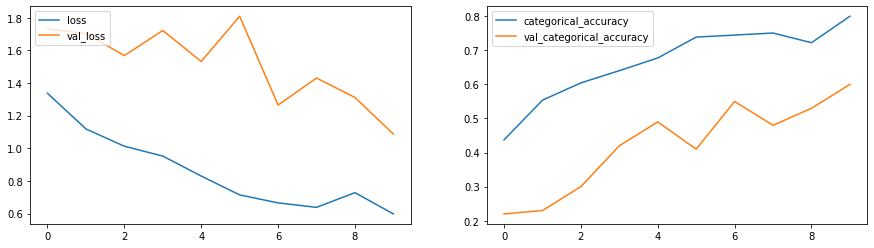

In [52]:
plot(history)

In [53]:
df1 = model_result("Model_8_CNN_LSTM",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

                   Model Name  Model Accuracy  ...  Val Accuracy     Val Loss
0             Model_1_Vanilla       47.014925  ...     33.000001  3748.384857
0                 Model_3_SGD       69.402987  ...     47.000000  1007.729626
0              Model_2_Tuning       91.194028  ...     43.000001   379.239225
0              Model_2_Add_HL       81.492537  ...     51.999998   541.738272
0              Model_5_Tuning       68.656719  ...     30.000001   427.992392
0             Model_6_CNN_RNN       88.507462  ...     63.999999    93.978983
0  Model_7_CNN_RNN_Add_Tuning       85.820895  ...     56.999999   115.549910
0            Model_8_CNN_LSTM       80.000001  ...     60.000002   108.709717

[8 rows x 5 columns]


# Model 9: CNN + LSTM Network(Added more cells, Removed Hidden Layer, Added Dropout)

In [54]:
model = Sequential()

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu'),input_shape = input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.3))


model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.3))

model.add(TimeDistributed(Flatten()))


model.add(LSTM(512))

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(5, activation='softmax'))


optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_39 (TimeDis (None, 20, 120, 120, 32)  896       
_________________________________________________________________
time_distributed_40 (TimeDis (None, 20, 120, 120, 32)  128       
_________________________________________________________________
time_distributed_41 (TimeDis (None, 20, 60, 60, 32)    0         
_________________________________________________________________
time_distributed_42 (TimeDis (None, 20, 60, 60, 64)    18496     
_________________________________________________________________
time_distributed_43 (TimeDis (None, 20, 60, 60, 64)    256       
_________________________________________________________________
time_distributed_44 (TimeDis (None, 20, 30, 30, 64)    0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 20, 30, 30, 64)   

In [55]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
67/67 [==============================] - 64s 924ms/step - loss: 1.6979 - categorical_accuracy: 0.2701 - val_loss: 1.8109 - val_categorical_accuracy: 0.1800

Epoch 00001: val_loss did not improve from 0.93979
Epoch 2/10
67/67 [==============================] - 62s 934ms/step - loss: 1.3360 - categorical_accuracy: 0.4338 - val_loss: 2.8045 - val_categorical_accuracy: 0.2400

Epoch 00002: val_loss did not improve from 0.93979
Epoch 3/10
67/67 [==============================] - 62s 936ms/step - loss: 1.1243 - categorical_accuracy: 0.5230 - val_loss: 2.4327 - val_categorical_accuracy: 0.2500

Epoch 00003: val_loss did not improve from 0.93979

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/10
67/67 [==============================] - 62s 932ms/step - loss: 0.9649 - categorical_accuracy: 0.6305 - val_loss: 2.3671 - val_categorical_accuracy: 0.2500

Epoch 00004: val_loss did not improve from 0.93979
Epoch 5/10
67/67 [========================

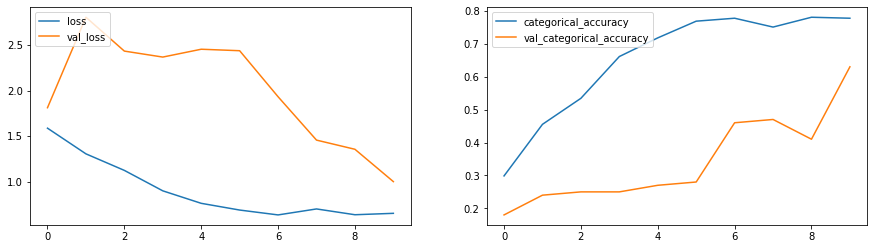

In [56]:
plot(history)

In [57]:
df1 = model_result( "Model_9_CNN_LSTM_Tune", history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

                   Model Name  Model Accuracy  ...  Val Accuracy     Val Loss
0             Model_1_Vanilla       47.014925  ...     33.000001  3748.384857
0                 Model_3_SGD       69.402987  ...     47.000000  1007.729626
0              Model_2_Tuning       91.194028  ...     43.000001   379.239225
0              Model_2_Add_HL       81.492537  ...     51.999998   541.738272
0              Model_5_Tuning       68.656719  ...     30.000001   427.992392
0             Model_6_CNN_RNN       88.507462  ...     63.999999    93.978983
0  Model_7_CNN_RNN_Add_Tuning       85.820895  ...     56.999999   115.549910
0            Model_8_CNN_LSTM       80.000001  ...     60.000002   108.709717
0       Model_9_CNN_LSTM_Tune       77.761191  ...     63.000000    99.936372

[9 rows x 5 columns]


#  Model 10 : CNN + GRU Network 

In [58]:
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape = input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))


model.add(GRU(256))

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(5, activation='softmax'))


optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_49 (TimeDis (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_50 (TimeDis (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_51 (TimeDis (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_52 (TimeDis (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_53 (TimeDis (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_54 (TimeDis (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_55 (TimeDis (None, 20, 30, 30, 64)   

In [59]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
67/67 [==============================] - 62s 913ms/step - loss: 1.5987 - categorical_accuracy: 0.3750 - val_loss: 2.7131 - val_categorical_accuracy: 0.2100

Epoch 00001: val_loss did not improve from 0.93979
Epoch 2/10
67/67 [==============================] - 61s 922ms/step - loss: 1.1203 - categorical_accuracy: 0.5468 - val_loss: 2.4512 - val_categorical_accuracy: 0.2200

Epoch 00002: val_loss did not improve from 0.93979
Epoch 3/10
67/67 [==============================] - 61s 917ms/step - loss: 0.8799 - categorical_accuracy: 0.6323 - val_loss: 2.9166 - val_categorical_accuracy: 0.2300

Epoch 00003: val_loss did not improve from 0.93979
Epoch 4/10
67/67 [==============================] - 60s 912ms/step - loss: 0.7762 - categorical_accuracy: 0.7100 - val_loss: 2.9802 - val_categorical_accuracy: 0.2100

Epoch 00004: val_loss did not improve from 0.93979

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/10
67/67 [========================

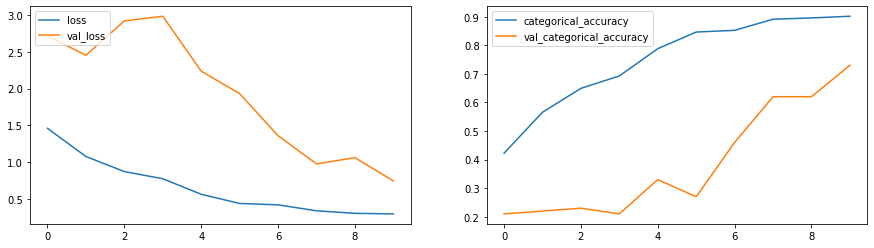

In [60]:
plot(history)

In [61]:
df1 = model_result("Model_10_CNN_GRU", history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

                   Model Name  Model Accuracy  ...  Val Accuracy     Val Loss
0             Model_1_Vanilla       47.014925  ...     33.000001  3748.384857
0                 Model_3_SGD       69.402987  ...     47.000000  1007.729626
0              Model_2_Tuning       91.194028  ...     43.000001   379.239225
0              Model_2_Add_HL       81.492537  ...     51.999998   541.738272
0              Model_5_Tuning       68.656719  ...     30.000001   427.992392
0             Model_6_CNN_RNN       88.507462  ...     63.999999    93.978983
0  Model_7_CNN_RNN_Add_Tuning       85.820895  ...     56.999999   115.549910
0            Model_8_CNN_LSTM       80.000001  ...     60.000002   108.709717
0       Model_9_CNN_LSTM_Tune       77.761191  ...     63.000000    99.936372
0            Model_10_CNN_GRU       90.149254  ...     73.000002    74.813592

[10 rows x 5 columns]


#  Model 11 : CNN + GRU Network(Added more cells, Added Hidden Layer, Added Dropout)

In [62]:
model = Sequential()

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu'),input_shape = input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.5))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.5))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.5))


model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.5))

model.add(TimeDistributed(Flatten()))


model.add(GRU(512))

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))


optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_62 (TimeDis (None, 20, 120, 120, 64)  1792      
_________________________________________________________________
time_distributed_63 (TimeDis (None, 20, 120, 120, 64)  256       
_________________________________________________________________
time_distributed_64 (TimeDis (None, 20, 60, 60, 64)    0         
_________________________________________________________________
time_distributed_65 (TimeDis (None, 20, 60, 60, 64)    36928     
_________________________________________________________________
time_distributed_66 (TimeDis (None, 20, 60, 60, 64)    256       
_________________________________________________________________
time_distributed_67 (TimeDis (None, 20, 30, 30, 64)    0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 20, 30, 30, 64)  

In [63]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
67/67 [==============================] - 65s 926ms/step - loss: 1.9605 - categorical_accuracy: 0.3016 - val_loss: 3.0524 - val_categorical_accuracy: 0.1600

Epoch 00001: val_loss did not improve from 0.74814
Epoch 2/10
67/67 [==============================] - 61s 927ms/step - loss: 1.3769 - categorical_accuracy: 0.4190 - val_loss: 3.6112 - val_categorical_accuracy: 0.2100

Epoch 00002: val_loss did not improve from 0.74814
Epoch 3/10
67/67 [==============================] - 62s 931ms/step - loss: 1.1362 - categorical_accuracy: 0.5529 - val_loss: 4.3050 - val_categorical_accuracy: 0.1300

Epoch 00003: val_loss did not improve from 0.74814

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/10
67/67 [==============================] - 61s 928ms/step - loss: 0.9729 - categorical_accuracy: 0.6201 - val_loss: 3.2788 - val_categorical_accuracy: 0.2500

Epoch 00004: val_loss did not improve from 0.74814
Epoch 5/10
67/67 [========================

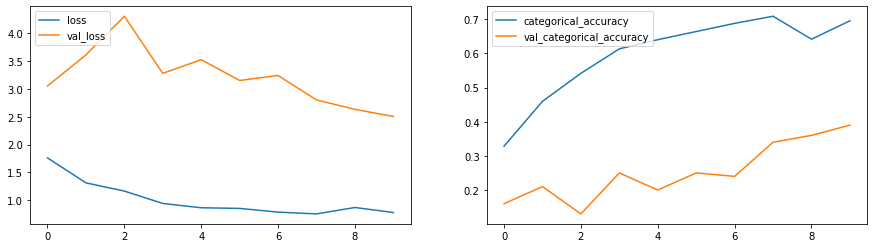

In [64]:
plot(history)

In [65]:
df1 = model_result("Model_11_CNN_GRU_Tuning",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

                   Model Name  Model Accuracy  ...  Val Accuracy     Val Loss
0             Model_1_Vanilla       47.014925  ...     33.000001  3748.384857
0                 Model_3_SGD       69.402987  ...     47.000000  1007.729626
0              Model_2_Tuning       91.194028  ...     43.000001   379.239225
0              Model_2_Add_HL       81.492537  ...     51.999998   541.738272
0              Model_5_Tuning       68.656719  ...     30.000001   427.992392
0             Model_6_CNN_RNN       88.507462  ...     63.999999    93.978983
0  Model_7_CNN_RNN_Add_Tuning       85.820895  ...     56.999999   115.549910
0            Model_8_CNN_LSTM       80.000001  ...     60.000002   108.709717
0       Model_9_CNN_LSTM_Tune       77.761191  ...     63.000000    99.936372
0            Model_10_CNN_GRU       90.149254  ...     73.000002    74.813592
0     Model_11_CNN_GRU_Tuning       69.552237  ...     38.999999   250.432110

[11 rows x 5 columns]


This is the end of the execution and the results and final conclusions are documented in the writeup. We have put all our experiment as part of notebook but the final model is chosen "Model_10_CNN_GRU"